<a href="https://colab.research.google.com/github/rkatzin/COVID19/blob/main/COVID19_Toronto_ICU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [2]:
# Data Source: City of Toronto Open Data COVID-19 Cases in Toronto dataset
# https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "64b54586-6180-4485-83eb-81e8fae3b8fe"}
package = requests.get(url, params = params).json()

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 1000000 }  # if you don't set limit, it only returns 100 rows! Curr about 125K rows 
        downloaded_data = requests.get(url, params = p).json()
        data = pd.DataFrame(downloaded_data["result"]["records"])
        break

print("Data downloaded {}".format(datetime.date.today()))
print("{} records".format(data.shape[0]))

Data downloaded 2021-04-23
135575 records


See https://open.toronto.ca/dataset/covid-19-cases-in-toronto/ for description of features

In particular,

| Feature | Description |
|:------- |:----------------------------------------------------------- |
|Episode Date |	The episode date is a derived variable that best estimates when the disease was acquired, and refers to the earliest available date from: symptom onset<br>  (the first day that COVID-19 symptoms occurred), laboratory specimen collection date, or reported date.
|Reported Date | The date on which the case was reported to Toronto Public Health.|
|Outcome<br><br><br><br><br><br>| **FATAL:** Cases with a fatal outcome reported.<br>**RESOLVED:** Cases not reported as deceased, and who are either:<list><li>Reported as 'recovered' OR<li>Where the report date is more than 14 days from symptom onset AND the case is not currently hospitalized.</list><br>This number is underreported due to a lag in data entry.<br>**ACTIVE:** All other cases|
|Ever in ICU|Cases that were admitted to the intensive care unit (ICU) related to their COVID-19 infection (includes cases that are currently in ICU and those that have been discharged or are deceased).|


### **Cases acquired between January 1, 2021 and March 15, 2021**

In [3]:
# Convert Episode Date to proper datetime format
data['Formatted Date'] = pd.to_datetime(data['Episode Date'])

# Select all cases acquired between Jan 1, 2021 and March 15, 2021 
Total_Cases_Jan_1_to_Mar_15_2021 = data[(data['Formatted Date']>=np.datetime64('2021-01-01')) &
                                        (data['Formatted Date']<=np.datetime64('2021-03-15'))]

# Select cases acquired between Jan 1, 2021 and March 15, 2021 that were admitted to ICU
Cases_Jan_1_to_Mar_15_2021_ever_in_ICU = data[(data['Formatted Date']>=np.datetime64('2021-01-01')) &
                                              (data['Formatted Date']<=np.datetime64('2021-03-15')) &
                                              (data['Ever in ICU']=='Yes')]

ICU_Outcomes = Cases_Jan_1_to_Mar_15_2021_ever_in_ICU.Outcome.value_counts()

print("Total cases acquired between Jan 1, 2021 and March 15, 2021: {}".format(Total_Cases_Jan_1_to_Mar_15_2021.shape[0]))
print("Percentage admitted to ICU: {}/{} = {} %".format(ICU_Outcomes.sum(),Total_Cases_Jan_1_to_Mar_15_2021.shape[0], 
                                                        round(100 * ICU_Outcomes.sum() / Total_Cases_Jan_1_to_Mar_15_2021.shape[0], 2)))
print("\nOutcomes for cases acquired between Jan 1, 2021 and March 15, 2021 that were admitted to ICU:")
print(ICU_Outcomes.to_string())
print("\nTotal cases acquired between Jan 1, 2021 and March 15, 2021 that were admitted to ICU: {}".format(ICU_Outcomes.sum()))
print("Percentage fatal: {}/{} = {} %".format(ICU_Outcomes.FATAL, ICU_Outcomes.sum(), round(100 * ICU_Outcomes.FATAL / ICU_Outcomes.sum(), 2)))

Total cases acquired between Jan 1, 2021 and March 15, 2021: 38762
Percentage admitted to ICU: 289/38762 = 0.75 %

Outcomes for cases acquired between Jan 1, 2021 and March 15, 2021 that were admitted to ICU:
RESOLVED    139
FATAL       125
ACTIVE       25

Total cases acquired between Jan 1, 2021 and March 15, 2021 that were admitted to ICU: 289
Percentage fatal: 125/289 = 43.25 %


### **Breakdowns by Age Group; Rolling Averages**

Per City of Toronto website, the data are extracted at 3 PM on the Monday of a given week, and posted by Wednesday.  

#### **Allowances for reporting lags**
Allow 15 day lag between episode date and report of ICU admission

Allow 30 day lag between episode date and report of death

#####**Clinical Progression: Time to ICU Admission**
Per CDC https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html

>Among patients in multiple early studies from Wuhan, China who had severe COVID-19 illness, the median time from their onset of illness to the time they experienced dyspnea was 5–8 days; the median time from onset of illness to acute respiratory distress syndrome (ARDS) was 8–12 days; and the median time from onset of illness to ICU admission was 9.5–12 days.(5,6,37,38) Clinicians should be aware of the potential for some patients with COVID-19 to rapidly deteriorate about one week after illness onset.

##### **Time to Death**
Per https://doi.org/10.1016/S0140-6736(20)30566-3, Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study, The Lancet, March 11, 2020

>The median time from illness onset (ie, before admission) to discharge was 22·0 days (IQR 18·0–25·0), whereas the median time to death was 18·5 days (15·0–22·0; table 2).

In [4]:
cutoff_date_for_ICU_admit_stats = pd.to_datetime(data['Reported Date']).max() - np.timedelta64(15, 'D')
cutoff_date_for_death_stats = pd.to_datetime(data['Reported Date']).max() - np.timedelta64(30, 'D')


### **Cases that end up in ICU, breakdown by age** 

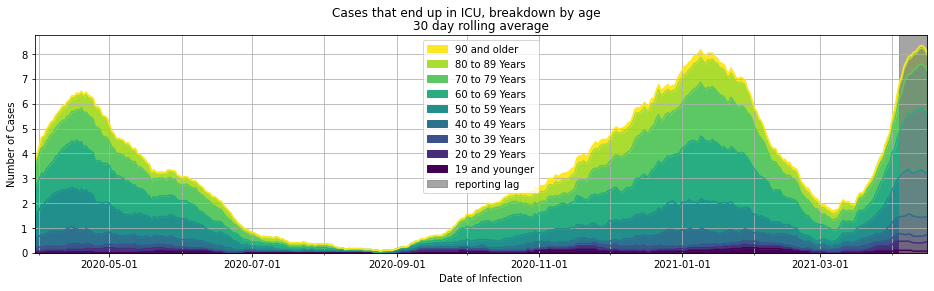

In [5]:
window=30
icu_cases=data[data['Ever in ICU']=='Yes']
age_bands=icu_cases['Age Group'].unique().tolist()
age_bands.sort()
icu_cases_by_age = icu_cases.groupby(['Formatted Date','Age Group']).size().unstack(level=-1)
icu_cases_by_age = icu_cases_by_age.resample('D').asfreq().fillna(0)
icu_cases_by_age_roll = icu_cases_by_age.rolling(window).mean().dropna()

plt.figure(figsize=(16,4))
plt.suptitle('Cases that end up in ICU, breakdown by age')
plt.title('{} day rolling average'.format(window))
colors = [plt.get_cmap('viridis').colors[idx] for idx in (np.linspace(0, 255, len(age_bands))).astype(int)]
# colors = plt.get_cmap('tab10').colors
bottom = np.zeros(icu_cases_by_age_roll.shape[0])
for i in range(len(age_bands)):
  # stack the age bands by plotting the sum of all age bands up to the current one
  line_to_plot = icu_cases_by_age_roll[age_bands[0:i+1]].sum(axis=1)
  plt.plot(line_to_plot, color=colors[i])
  plt.fill_between(icu_cases_by_age_roll.index, bottom, line_to_plot, color=colors[i], label=age_bands[i])
  bottom = line_to_plot # move bottom of fill up to next age band
plt.xticks(ticks=icu_cases_by_age_roll.resample('2MS').asfreq().index)
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.grid(True, which='minor')
plt.xlim(icu_cases_by_age_roll.index[0],icu_cases_by_age_roll.index[-1])
plt.ylim(0,plt.ylim()[1])
plt.xlabel('Date of Infection')
plt.ylabel('Number of Cases')
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_ICU_admit_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles.append(lag_area)
plt.legend(handles=handles)
plt.grid()
plt.show()  


>>>**How to read the graph:** The top of the curve shows how many of the cases acquired on a given date end up in ICU. The coloured bands show the breakdown of that number by age group.  A rolling average is used for smoothing. For example, for each day in early January 2021, on average about 7 or 8 of the new COVID-19 cases acquired on that day ultimately ended up in ICU.  Of those 7 or 8 cases, approximately 2 were age 70-79, 2 were age 60-69,  1 was 80-89, 1 was 50-59, etc.


### **Percentage of cases that end up in ICU, breakdown by age**

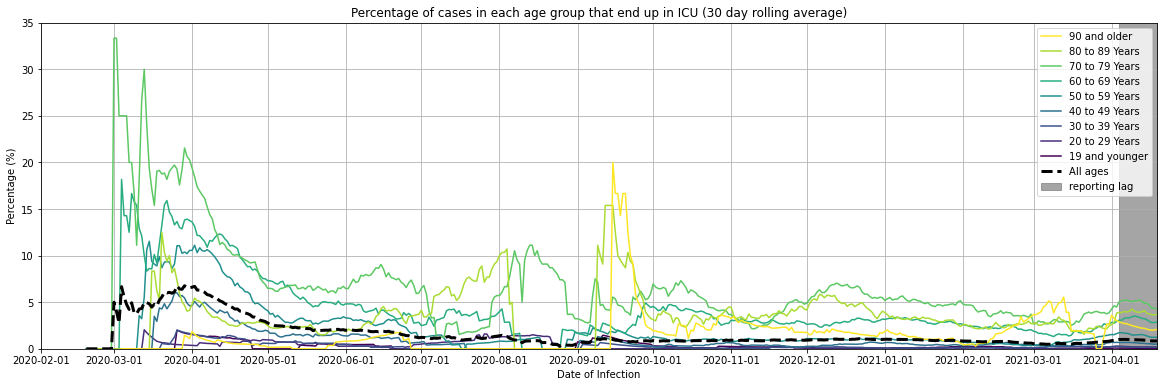

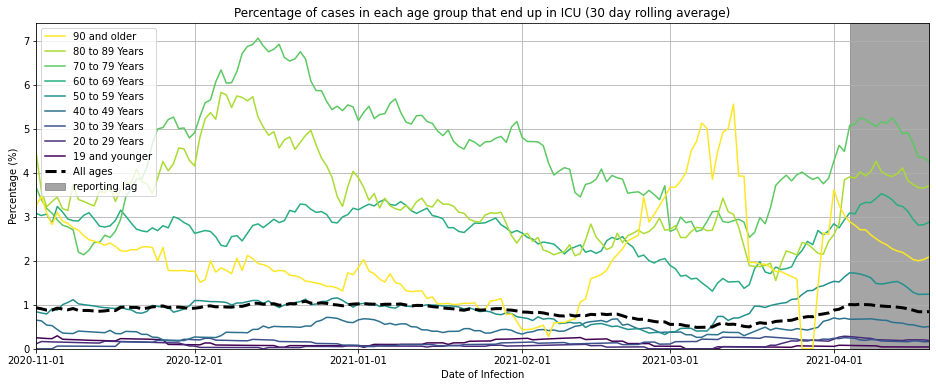

In [6]:
window = 30
min_periods = window if window < 30 else 30
by_date_age_icu = data.groupby(['Formatted Date','Age Group','Ever in ICU']).size().unstack(level=-1,fill_value=0)
by_date_age_icu['TOTAL'] = by_date_age_icu.sum(axis=1)
by_date_age_icu = by_date_age_icu.unstack(level=-1, fill_value=0)
by_date_age_icu = by_date_age_icu.resample('D').asfreq().fillna(0)
by_date_age_icu_roll = by_date_age_icu.rolling(window=window, min_periods=min_periods).sum().dropna()

plt.figure(figsize=(20,6))
plt.title('Percentage of cases in each age group that end up in ICU ({} day rolling average)'.format(window))
colors = [plt.get_cmap('viridis').colors[idx] for idx in np.floor(np.linspace(0, 255, len(age_bands))).astype(int)]
# colors = plt.get_cmap('tab10').colors
for i in range(len(age_bands)):
  plt.plot(100*by_date_age_icu_roll['Yes'][age_bands[i]]/by_date_age_icu_roll.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
all_ages = plt.plot(100*by_date_age_icu_roll['Yes'].sum(axis=1)/by_date_age_icu_roll.TOTAL.sum(axis=1),
           linestyle='--', linewidth=3, color='k', label='All ages')    
handles.append(all_ages[0])
plt.xlim(by_date_age_icu_roll.index[0],by_date_age_icu_roll.index[-1])
plt.ylim(0,plt.ylim()[1])
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_ICU_admit_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles.append(lag_area)
plt.xticks(ticks=by_date_age_icu_roll.resample('MS').asfreq().index)
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend(handles=handles)
plt.grid()
plt.show()

# Nov 2020 onward
plt.figure(figsize=(16,6))
plt.title('Percentage of cases in each age group that end up in ICU ({} day rolling average)'.format(window))
start_date_string = '2020-11-01'
subset=by_date_age_icu_roll.loc[np.datetime64(start_date_string):]
for i in range(len(age_bands)):
  plt.plot(100*subset['Yes'][age_bands[i]]/subset.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
all_ages = plt.plot(100*subset['Yes'].sum(axis=1)/subset.TOTAL.sum(axis=1), linestyle='--', linewidth=3, color='k', label='All ages')    
handles.append(all_ages[0])
plt.xlim(subset.index[0],subset.index[-1])
plt.ylim(0,plt.ylim()[1])
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_ICU_admit_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles.append(lag_area)
plt.xticks(ticks=subset.resample('MS').asfreq().index)
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend(handles=handles)
plt.grid()
plt.show() 

### **Death rate of cases admitted to ICU, breakdown by age**

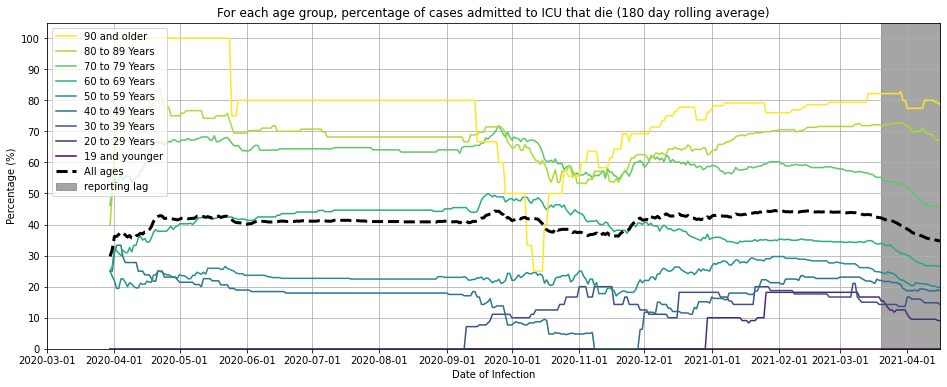

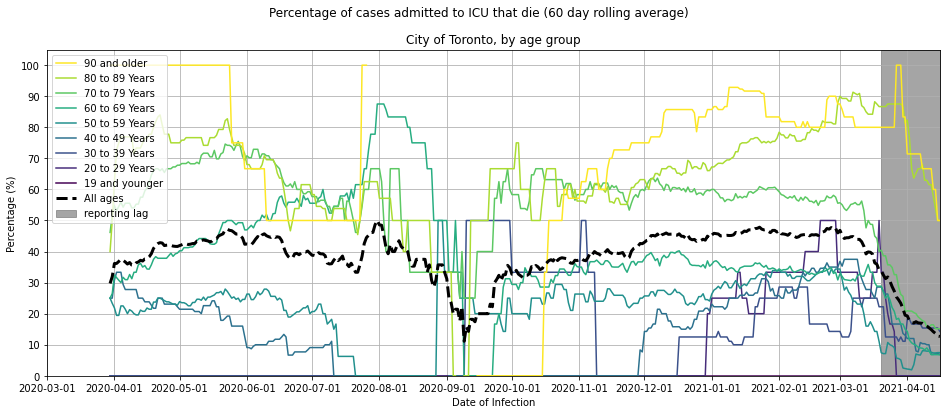

In [12]:
window = 180
min_periods = window if window < 30 else 30
icu_cases=data[data['Ever in ICU']=='Yes']
by_date_age_outcome = icu_cases.groupby(['Formatted Date','Age Group','Outcome']).size().unstack(level=-1,fill_value=0)
by_date_age_outcome['TOTAL'] = by_date_age_outcome.sum(axis=1)
by_date_age_outcome = by_date_age_outcome.unstack(level=-1, fill_value=0)
by_date_age_outcome = by_date_age_outcome.resample('D').asfreq().fillna(0)
by_date_age_outcome_roll = by_date_age_outcome.rolling(window=window, min_periods=min_periods).sum().dropna()

plt.figure(figsize=(16,6))
plt.title('For each age group, percentage of cases admitted to ICU that die ({} day rolling average)'.format(window))
colors = [plt.get_cmap('viridis').colors[idx] for idx in np.floor(np.linspace(0, 255, len(age_bands))).astype(int)]
# colors = plt.get_cmap('tab10').colors
for i in range(len(age_bands)):
  plt.plot(100*by_date_age_outcome_roll.FATAL[age_bands[i]]/by_date_age_outcome_roll.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
all_ages = plt.plot(100*by_date_age_outcome_roll.FATAL.sum(axis=1)/by_date_age_outcome_roll.TOTAL.sum(axis=1),
           linestyle='--', linewidth=3, color='k', label='All ages')    
handles.append(all_ages[0])
plt.xlim(by_date_age_outcome_roll.index[0],by_date_age_outcome_roll.index[-1])
plt.ylim(0,plt.ylim()[1])
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_death_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles.append(lag_area)
plt.xticks(ticks=by_date_age_outcome_roll.resample('MS').asfreq().index)
plt.yticks(ticks=np.linspace(0,100,11))
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend(handles=handles)
plt.grid()
plt.show()

window = 60
min_periods = window if window < 30 else 30
by_date_age_outcome_roll = by_date_age_outcome.rolling(window=window, min_periods=min_periods).sum().dropna()
plt.figure(figsize=(16,6))
plt.suptitle('Percentage of cases admitted to ICU that die ({} day rolling average)'.format(window))
plt.title('City of Toronto, by age group')
for i in range(len(age_bands)):
  plt.plot(100*by_date_age_outcome_roll.FATAL[age_bands[i]]/by_date_age_outcome_roll.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
all_ages = plt.plot(100*by_date_age_outcome_roll.FATAL.sum(axis=1)/by_date_age_outcome_roll.TOTAL.sum(axis=1),
           linestyle='--', linewidth=3, color='k', label='All ages')  
handles.append(all_ages[0])
plt.xlim(by_date_age_outcome_roll.index[0],by_date_age_outcome_roll.index[-1])
plt.ylim(0,plt.ylim()[1])
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_death_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles.append(lag_area)
plt.xticks(ticks=by_date_age_outcome_roll.resample('MS').asfreq().index)
plt.yticks(ticks=np.linspace(0,100,11))
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend(handles=handles)
plt.grid()
plt.show()

### **Percentage of cases with fatal outcome, breakdown by age**

In [8]:
# mortality rates per 1000 in Canada for 2019 from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310071001
mort_rates_per_thou = np.array([['<1', 4.4],['1-4', 0.2],['5-9', 0.1],['10-14', 0.1],['15-19', 0.3],['20-24', 0.5],['25-29', 0.7],
                                ['30-34', 0.8],['35-39', 0.9],['40-44', 1.2],['45-49', 1.8],['50-54', 2.8],['55-59', 4.5],['60-64', 7.0],
                                ['65-69', 10.8],['70-74', 17.1],['75-79', 27.9],['80-84', 49.1],['85-89', 88.8],['90+', 188.4]])
mort_rates = pd.DataFrame(mort_rates_per_thou, columns=['age','rate_per_thou']).set_index('age')
mort_rates['pct_rate'] = mort_rates.rate_per_thou.apply(lambda x: float(x)/10)
mort_rates['age_band_idx'] = pd.Series([0,0,0,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8], index=mort_rates.index)
mort_pct_rates = mort_rates.groupby('age_band_idx').mean()
mort_pct_rates.set_index(mort_pct_rates.reset_index().age_band_idx.apply(lambda x: age_bands[x]), inplace=True)
mort_pct_rates

,pct_rate
age_band_idx,
19 and younger,0.102
20 to 29 Years,0.060
30 to 39 Years,0.085
40 to 49 Years,0.150
50 to 59 Years,0.365
60 to 69 Years,0.890
70 to 79 Years,2.250
80 to 89 Years,6.895
90 and older,18.840


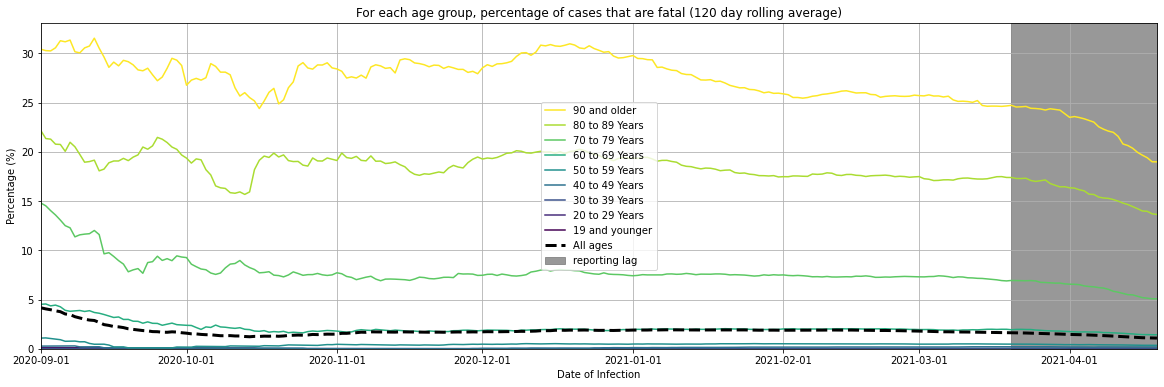

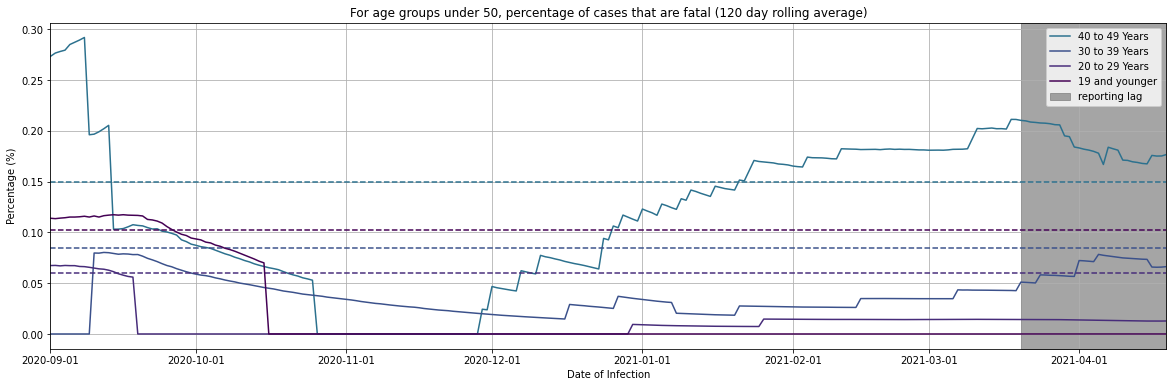

In [9]:
window = 120
min_periods = window if window < 30 else 30
by_date_age_fatal = data.groupby(['Formatted Date','Age Group','Outcome']).size().unstack(level=-1,fill_value=0)
by_date_age_fatal['TOTAL'] = by_date_age_fatal.sum(axis=1)
by_date_age_fatal = by_date_age_fatal.unstack(level=-1, fill_value=0)
by_date_age_fatal = by_date_age_fatal.resample('D').asfreq().fillna(0)
by_date_age_fatal_roll = by_date_age_fatal.rolling(window=window, min_periods=min_periods).sum().dropna()

subset=by_date_age_fatal_roll.loc[np.datetime64('2020-09-01'):]
plt.figure(figsize=(20,6))
plt.title('For each age group, percentage of cases that are fatal ({} day rolling average)'.format(window))
colors = [plt.get_cmap('viridis').colors[idx] for idx in np.floor(np.linspace(0, 255, len(age_bands))).astype(int)]
# colors = plt.get_cmap('tab10').colors
for i in range(len(age_bands)):
  plt.plot(100*subset['FATAL'][age_bands[i]]/subset.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
# reverse order of entries in legend to align with their arrangement in the graph (oldest age on top)
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
all_ages = plt.plot(100*subset['FATAL'].sum(axis=1)/subset.TOTAL.sum(axis=1), linestyle='--', linewidth=3, color='k', label='All ages')  
handles.append(all_ages[0])
plt.xlim(subset.index[0],subset.index[-1])
plt.ylim(0,plt.ylim()[1])
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_death_stats, plt.xlim()[1], color='tab:gray', alpha=0.8, label='reporting lag')
handles.append(lag_area)
plt.xticks(ticks=subset.resample('MS').asfreq().index)
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend(handles=handles)
plt.grid()
plt.show()

# youngest age categories
plt.figure(figsize=(20,6))
plt.title('For age groups under 50, percentage of cases that are fatal ({} day rolling average)'.format(window))
for i in range(3,-1,-1):  # only look at youngest 4 age categories
  plt.plot(100*subset['FATAL'][age_bands[i]]/subset.TOTAL[age_bands[i]],color=colors[i],
           label=age_bands[i])
  plt.axhline(y=mort_pct_rates.loc[age_bands[i]].pct_rate, linestyle='--', color=colors[i])
plt.xlim(subset.index[0],subset.index[-1])
plt.ylim(plt.ylim()[0],plt.ylim()[1])
plt.xticks(ticks=subset.resample('MS').asfreq().index)
# shade area to the right of cutoff date
lag_area = plt.fill_betweenx(plt.ylim(), cutoff_date_for_death_stats, plt.xlim()[1], color='tab:gray', alpha=0.7, label='reporting lag')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(Line2D([0], [0], color='k', linestyle='--', label='Statscan 2019 mortality rates by age group'))
plt.xlabel('Date of Infection')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid()
plt.show()    